# BLISS walkthrough

The following steps are shown in this notebook:

0. install dependencies
1. load file from disk
2. visualize data before any manipulation (rough sanity check we're interpreting files correctly)
3. set mask bits using various flaggers (spectral kurtosis and filter roll-off)
4. estimate noise statistics (noise floor + noise power)
5. integrate along different drift rates
6. :-|

In [1]:
# These are always good to have loaded and ipympl makes the interactive plots work

!pip install numpy matplotlib ipympl
# h5py hdf5plugin  scipy


The following will assume this is in something like the "notebooks" folder inside bliss, and everything is already built in the `build/` directory of bliss

In [2]:
import sys
if "../build/bliss/python" not in sys.path:
    sys.path.append("../build/bliss/python/")
import pybliss

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt

# don't need these where we're going!
# import h5py
# import hdf5plugin

Set these locations and paths according to specific data to look at...

In [3]:
data_loc = "/home/nathan/datasets/voyager_2020_data/"
test_file = f"{data_loc}/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5"


In [4]:
# We've got an internal structure that reads hdf5 and dumps it to a neat class without exposing hdf5 much
# in c++, that class can take an already open hdf5 and I'd like to support that from h5py as well one day....
# for now, just give a path to an hdf5 file
# The more pressing thing is going to be reading in whole cadences at once
filterbank_file = pybliss.filterbank_data(test_file)


## Visualize data from disk

This shows reading an ndarray we read from disk in our own compute format and sharing it with numpy. The `from_dlpack` method is zero-copy. When the cuda backend comes in to town, this obviously won't work for CUDA-backed ndarrays, but you'll be able to do explicit data movements to copy to cpu, load to numpy, or load it to cupy for cuda operations.

/home/nathan/quadraturedev/customers/seti/bliss/.venv/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/nathan/quadraturedev/customers/seti/bliss/.venv/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


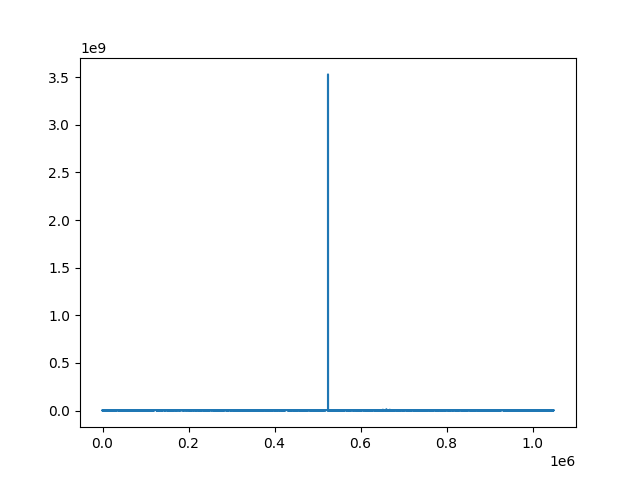

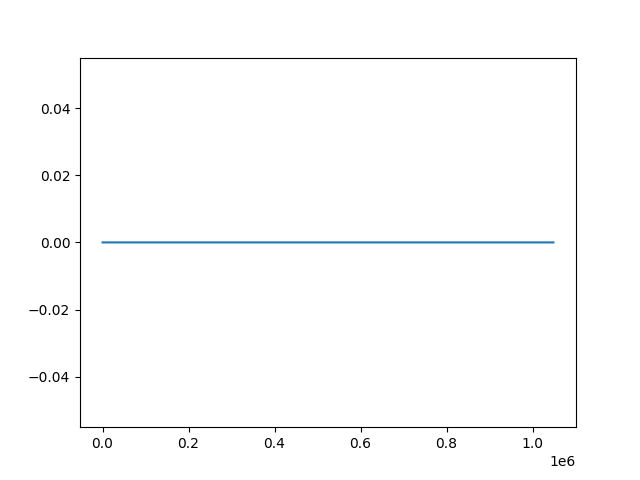

In [5]:
data_arr = np.from_dlpack(filterbank_file.data)
mask_arr = np.from_dlpack(filterbank_file.mask)

plt.figure()
plt.plot(np.mean(data_arr, 0))

plt.figure()
plt.plot(np.sum(mask_arr, 0))



In [6]:
signal_ampl = 8.8e6
noise_ampl = 5.5e6
noise_var = 319463620608


# noise floor of cropped spectrum: 5507229.0
# noise power of cropped spectrum: 319463620608.0


snr = (signal_ampl**2 - noise_ampl) / noise_var
print(f"estimated SNR: {snr}")
print(f"estimated SNR: {np.log10(snr)} dB")

estimated SNR: 242.40630076318854
estimated SNR: 2.384543904071482 dB


In [7]:


# sec_per_spectra = abs(1 / (1e6*filterbank_file.foff))
# N = int(filterbank_file.tsamp / sec_per_spectra)
# M = filterbank_file.data.size(0)
# print(N)

# sk = pybliss.estimators.estimate_spectral_kurtosis(filterbank_file.data, 51, M)

# plt.figure()
# plt.title("Spectral Kurtosis across Channel")
# plt.plot(np.from_dlpack(sk))

# plt.plot(np.from_dlpack(sk) > 2)
# plt.plot(np.from_dlpack(sk) < 0.05)

In [8]:


flagged_filterbank = pybliss.flaggers.flag_spectral_kurtosis(filterbank_file, 0.05, 5)

flagged_filterbank = pybliss.flaggers.flag_filter_rolloff(filterbank_file, 0.20)



spec kurtosis with M=16 and N=51


13424144
(16, 1048576)


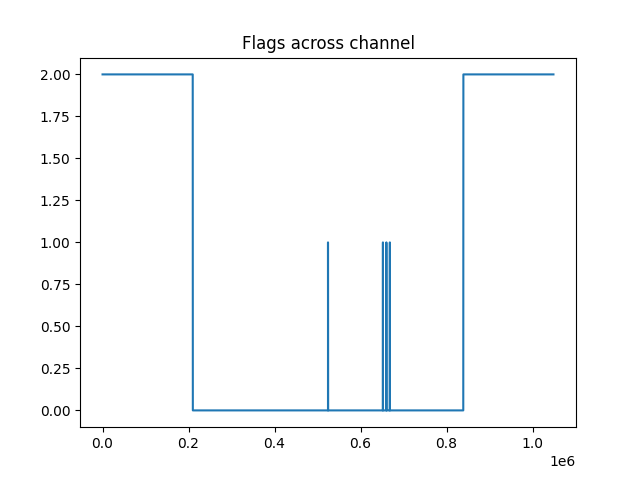

In [9]:
mask = np.from_dlpack(flagged_filterbank.mask)

print(mask.sum())
print(mask.shape)

plt.figure()
plt.title("Flags across channel")
plt.plot(mask.mean(0))

In [10]:
noise_est_slice = data_arr[:, 200000:500000]

print(noise_est_slice.shape)


(16, 300000)


In [11]:
print(np.mean(noise_est_slice))
m = pybliss.bland.mean(np.array(noise_est_slice))
print(np.from_dlpack(m))

print(np.sum(noise_est_slice) / noise_est_slice.size)

# numpy: 5507229.0
# np sum / size: 5507229.067946667

# with scale-as-you-go
# with float accumulator: 5450137.5
# with double accumulator: 5507228.5

# with scale-after
# with float accumulator: 5546422.5
# with double accumulator: 5507227.5



5507229.0
[5546422.5]
5507229.067946667


In [12]:

print(f"noise floor of cropped spectrum: {np.mean(noise_est_slice)}")
print(f"noise power of cropped spectrum: {np.var(noise_est_slice)}")


noise floor of cropped spectrum: 5507229.0
noise power of cropped spectrum: 319463620608.0


In [13]:
noise_est_options = pybliss.estimators.noise_power_estimate_options()
noise_est_options.masked_estimate = False
noise_est_options.estimator_method = pybliss.estimators.noise_power_estimator.stddev
noise_stats = pybliss.estimators.estimate_noise_power(flagged_filterbank, noise_est_options)

print(f"noise floor of spectrum (estimated without rfi mask): \t{noise_stats.noise_floor/1e6}")
print(f"noise power of spectrum (estimated without rfi mask): \t\t{noise_stats.noise_power/1e6}")
print("---")

noise_est_options = pybliss.estimators.noise_power_estimate_options()
noise_est_options.masked_estimate = True
noise_est_options.estimator_method = pybliss.estimators.noise_power_estimator.stddev
noise_stats = pybliss.estimators.estimate_noise_power(flagged_filterbank, noise_est_options)

print(f"noise floor of spectrum (estimated using rfi mask): \t{noise_stats.noise_floor/1e6}")
print(f"noise power of spectrum (estimated using rfi mask): \t\t{noise_stats.noise_power/1e6}")
print("---")

noise_est_options = pybliss.estimators.noise_power_estimate_options()
noise_est_options.masked_estimate = False
noise_est_options.estimator_method = pybliss.estimators.noise_power_estimator.mad
noise_stats = pybliss.estimators.estimate_noise_power(flagged_filterbank.data, noise_est_options)

print(f"noise floor of spectrum (estimated using MAD w/o mask): \t{noise_stats.noise_floor/1e6}")
print(f"noise power of spectrum (estimated using MAD w/o mask): \t{noise_stats.noise_power/1e6}")
print("---")


noise floor of spectrum (estimated without rfi mask): 	5.102699
noise power of spectrum (estimated without rfi mask): 		12746845.323264
---
noise floor of spectrum (estimated using rfi mask): 	5.183787
noise power of spectrum (estimated using rfi mask): 		418921.971712
---
noise floor of spectrum (estimated using MAD w/o mask): 	5.296965
noise power of spectrum (estimated using MAD w/o mask): 	231595.78624
---


In [14]:
noise_est_options = pybliss.estimators.noise_power_estimate_options()
noise_est_options.masked_estimate = False
noise_est_options.estimator_method = pybliss.estimators.noise_power_estimator.stddev
noise_stats = pybliss.estimators.estimate_noise_power(np.array(noise_est_slice), noise_est_options)

print(noise_stats.noise_floor)


5546422.5


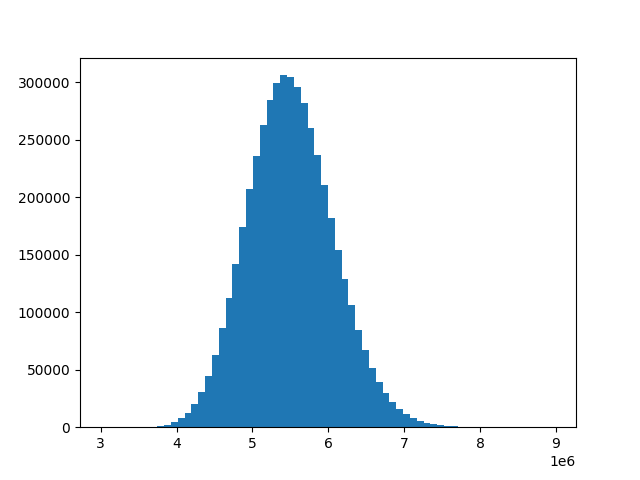

In [15]:
plt.figure()
_ = plt.hist(noise_est_slice.flatten(), bins=int(np.power(300000, 1/3)))

In [16]:
opts = pybliss.integrate_drifts_options()
opts.desmear = True
opts.low_rate = 0
opts.high_rate = 48
opts.rate_step_size = 1

dedrift = pybliss.drift_search.integrate_drifts(flagged_filterbank, opts)

drift step 0 (m=0)has 0 smeared channels, so 1 number_integrated_channels
drift step 1 (m=0.0666667)has 0 smeared channels, so 1 number_integrated_channels
drift step 2 (m=0.133333)has 0 smeared channels, so 1 number_integrated_channels
drift step 3 (m=0.2)has 0 smeared channels, so 1 number_integrated_channels
drift step 4 (m=0.266667)has 0 smeared channels, so 1 number_integrated_channels
drift step 5 (m=0.333333)has 0 smeared channels, so 1 number_integrated_channels
drift step 6 (m=0.4)has 0 smeared channels, so 1 number_integrated_channels
drift step 7 (m=0.466667)has 0 smeared channels, so 1 number_integrated_channels
drift step 8 (m=0.533333)has 1 smeared channels, so 1 number_integrated_channels
drift step 9 (m=0.6)has 1 smeared channels, so 1 number_integrated_channels
drift step 10 (m=0.666667)has 1 smeared channels, so 1 number_integrated_channels
drift step 11 (m=0.733333)has 1 smeared channels, so 1 number_integrated_channels
drift step 12 (m=0.8)has 1 smeared channels, so

In [17]:
det_plane_with_smear_correction = np.from_dlpack(dedrift.dedrifted_spectrum())

print(det_plane_with_smear_correction.shape)

(48, 1048576)


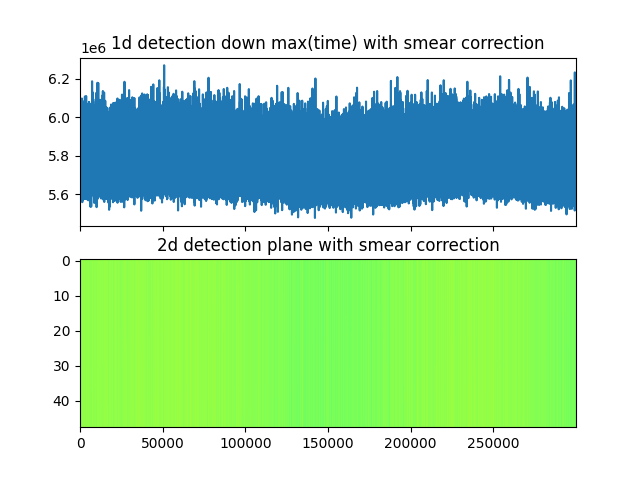

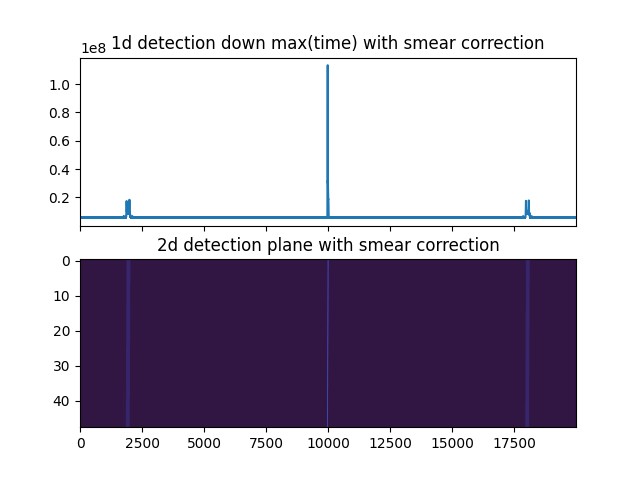

In [18]:

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.set_title("1d detection down max(time) with smear correction")
ax1.plot(det_plane_with_smear_correction[:, 200000:500000].max(0)/16)
plt.margins(0)

ax2.set_title("2d detection plane with smear correction")
ax2.imshow(det_plane_with_smear_correction[:, 200000:500000], aspect="auto", interpolation=None, cmap="turbo")


voyager_expect = 660000

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.set_title("1d detection down max(time) with smear correction")
ax1.plot(det_plane_with_smear_correction[:, voyager_expect-10000:voyager_expect+10000].max(0)/16)
plt.margins(0)

ax2.set_title("2d detection plane with smear correction")
ax2.imshow(det_plane_with_smear_correction[:, voyager_expect-10000:voyager_expect+10000], aspect="auto", interpolation=None, cmap="turbo")




In [19]:
signal_int = 8.58e6
noise_int = 5.5e6
int_length = 16
noise_after_int = 319463620608/np.sqrt(int_length)


# noise floor of cropped spectrum: 5507229.0
# noise power of cropped spectrum: 319463620608.0


snr = (signal_int**2 - noise_int) / noise_after_int
print(f"estimated SNR: {snr}")
print(f"estimated SNR: {np.log10(snr)} dB")

estimated SNR: 921.7499552517937
estimated SNR: 2.964613125194455 dB


In [20]:
thresh_at_snr10 = np.sqrt(noise_int + noise_after_int*10)
print(f"Our SNR=10 threshold would be at integrated amplitudes of {thresh_at_snr10}")


Our SNR=10 threshold would be at integrated amplitudes of 893680.34079306
